In [11]:
# Import statements
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import acf
import epyestim.covid19 as c19

In [34]:
# Preprocessing case data
cases21 = pd.read_csv('Data/newCasesPCROnlyBySpecimenDate_ltla_2021.csv')
cases21 = cases21[['date','area_code','area_name','value']]
cases20 = pd.read_csv('Data/newCasesPCROnlyBySpecimenDate_ltla_2020.csv')
cases20 = cases20[['date','area_code','area_name','value']]
cases20_additional = pd.read_csv('Data/ltla_2023-12-14 (1).csv')
cases20_additional.rename(columns={'newCasesBySpecimenDate':'value','areaCode':'area_code','areaName':'area_name'},inplace=True)
cases20_additional.drop(columns=['areaType','cumCasesBySpecimenDate','cumCasesBySpecimenDateRate'],inplace=True)
cases20_additional = cases20_additional[cases20_additional['area_name'].isin(cases20['area_name'].values)]
cases20_additional['date'] = pd.to_datetime(cases20_additional['date'])
cases20_additional = cases20_additional[cases20_additional['date'] < '2020-11-01']
cases20_additional = cases20_additional[cases20_additional['date'] >= '2020-10-01']
cases20 = pd.concat([cases20,cases20_additional]).sort_index()
pop = pd.read_csv('Data/census_estimate.csv')
# Rename columns and take weekly incidence instead of daily
cases = pd.concat([cases20,cases21])
cases['date'] = pd.to_datetime(cases['date'])
cases.set_index('date', inplace=True)
cases.sort_index(inplace=True)
weekly_counts_total = cases.groupby(['area_code','area_name']).rolling(7).sum().reset_index()

In [72]:
cases.to_csv('Data/cases_total.csv')

In [45]:
york = weekly_counts_total[weekly_counts_total['area_name']=='York'].drop(columns=['area_code','area_name']).rename(columns={'value':'Cases'}).set_index('date')['Cases']
york.dropna(inplace=True)


<Axes: xlabel='date'>

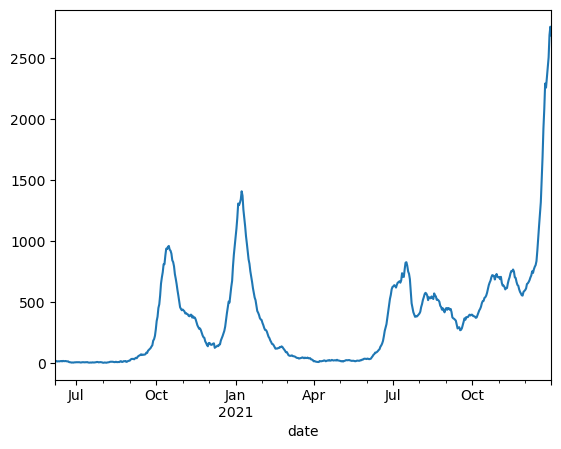

In [46]:
york.plot()

<Axes: >

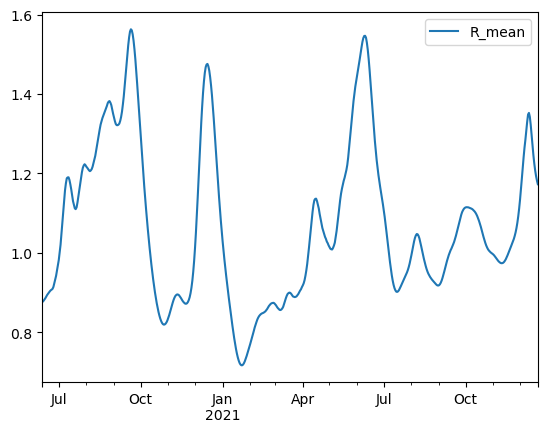

In [59]:
c19.r_covid(york,smoothing_window=42).plot(y='R_mean')

<Axes: >

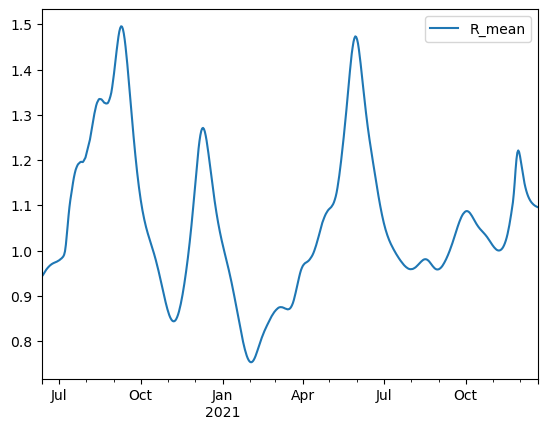

In [57]:
c19.r_covid(york,smoothing_window=70).plot(y='R_mean')

In [ ]:
from epyestim.distributions import discretise_gamma

<Axes: >

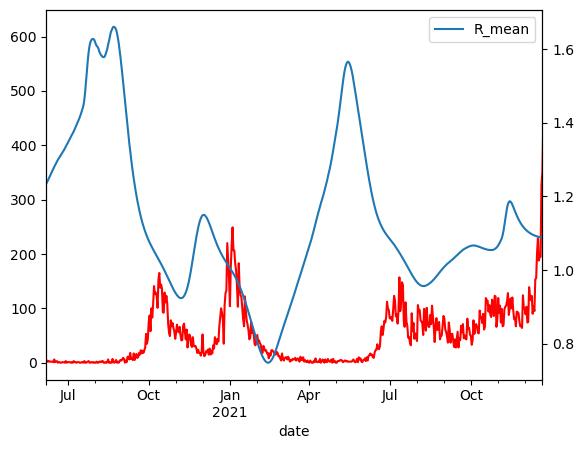

In [84]:
york2 = cases[cases['area_name']=='York'].drop(columns=['area_code','area_name']).rename(columns={'value':'Cases'})['Cases']
test = c19.r_covid(york2,smoothing_window=105,gt_distribution=discretise_gamma(8.5,0.62))

In [91]:
crossing_days = []
values = test['R_mean'].values
dates = york2.reset_index()['date'].values
# Loop through the values to find transitions through 1
for i in range(len(values) - 1):
    if (values[i] < 1 and values[i+1] > 1) or (values[i] > 1 and values[i+1] < 1):
        crossing_days.append(dates[i+1])

In [103]:
def find_critical_transitions(timeseries):
    fitted_r = c19.r_covid(timeseries,smoothing_window=70,gt_distribution=discretise_gamma(8.5,0.62))
    crossing_days = []
    values = fitted_r['R_mean'].values
    dates = timeseries.reset_index()['date'].values
    # Loop through the values to find transitions through 1
    for i in range(len(values) - 1):
        if (values[i] < 1 and values[i+1] > 1) or (values[i] > 1 and values[i+1] < 1):
            crossing_days.append(dates[i+1])
    return crossing_days

In [104]:
areas = np.unique(cases['area_name'].values)
crossing_dict = {}
for area in areas:
    timeseries = cases[cases['area_name']==area]['value']
    crossing_dict[area] = find_critical_transitions(timeseries)

In [138]:
min_len = 1
for region in crossing_dict.keys():
    if len(crossing_dict[region]) >= min_len:
        min_len = len(crossing_dict[region])
        min_region = region

In [140]:
min_len

9

In [139]:
min_region

'Sheffield'

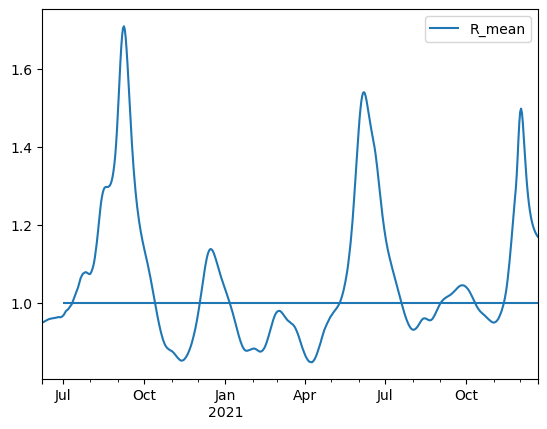

In [144]:
fig, ax = plt.subplots()
c19.r_covid(cases[cases['area_name']=='Sheffield']['value'],smoothing_window=63,gt_distribution=discretise_gamma(8.5,0.62)).plot(y='R_mean',ax=ax)
ax.hlines(1,xmin=pd.to_datetime('2020-07-01'),xmax=pd.to_datetime('2021-12-31'))

<Axes: xlabel='date'>

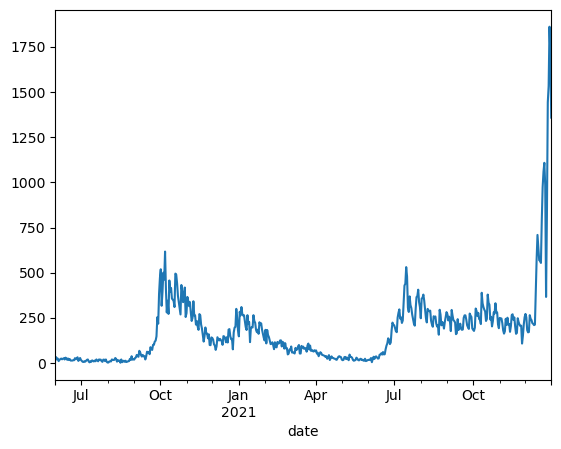

In [145]:
cases[cases['area_name']=='Sheffield']['value'].plot()

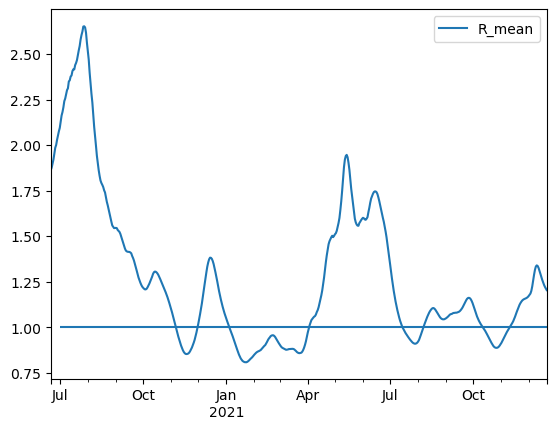

In [137]:
fig, ax = plt.subplots()
c19.r_covid(cases[cases['area_name']=='Wyre Forest']['value'],smoothing_window=49,gt_distribution=discretise_gamma(8.5,0.62)).plot(y='R_mean',ax=ax)
ax.hlines(1,xmin=pd.to_datetime('2020-07-01'),xmax=pd.to_datetime('2021-12-31'))

<Axes: xlabel='date'>

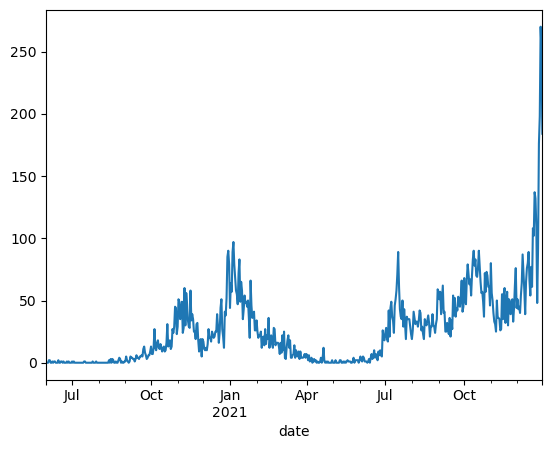

In [132]:
cases[cases['area_name']=='Wyre Forest']['value'].plot()

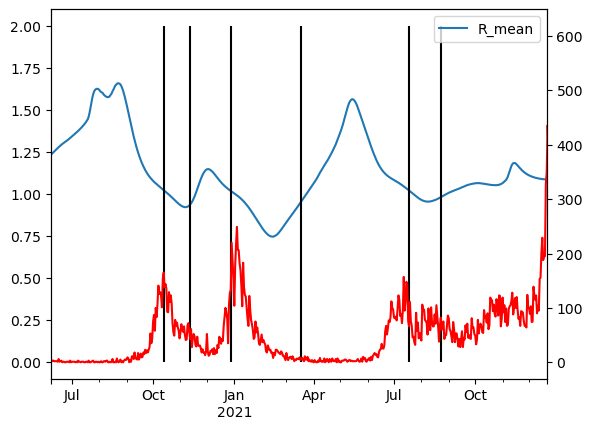

In [93]:
fig, axs = plt.subplots()
ax2 = axs.twinx()
york2.plot(ax=ax2,color='red')
test.plot(y='R_mean',ax=axs)
axs.vlines(crossing_days,ymin=0,ymax=2,color='k')